In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Dropout
from tensorflow.keras.activations import relu, linear, sigmoid
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score

from tqdm import tqdm
import os 

tqdm.pandas()

# my Helper functions

from HelperFunctions import *

## Plotando dados: TA x Spectral indices , TA X Spectral bands
### TA x (NDMI, MNDWI, PET) - I'll have to concatenate PET data

In [2]:
landsat_training_data = pd.read_csv('../Datasets/landsat_features_training.csv')
terra_climate_training_data = pd.read_csv('../Datasets/terraclimate_features_training.csv')
explained_variables = pd.read_csv('../Datasets/water_quality_training_dataset.csv')

joined_explaining_vars = combine_two_datasets(landsat_training_data, terra_climate_training_data)
full_dataset = combine_two_datasets(joined_explaining_vars, explained_variables)

# making sure the date of the smaples is converted to a numerical value, exploiting seasonality in the data, indicating seasonality
# maybe we can use neural networks specificaly typed to deal with time series
full_dataset['Sample Date'] = pd.to_datetime(full_dataset['Sample Date'], dayfirst=True)
#full_dataset['WeekOfYear'] = full_dataset['Sample Date'].dt.isocalendar().week.astype(int)
full_dataset['MonthOfYear'] = full_dataset['Sample Date'].dt.month
#MAX_CYCLE = 52
MAX_CYCLE = 12


# 4. Criar as features Sine e Cosine
#full_dataset['WOY_sin'] = np.sin(2 * np.pi * full_dataset['WeekOfYear'] / MAX_CYCLE)
#full_dataset['WOY_cos'] = np.cos(2 * np.pi * full_dataset['WeekOfYear'] / MAX_CYCLE)

full_dataset['Month_sin'] = np.sin(2 * np.pi * full_dataset['MonthOfYear'] / MAX_CYCLE)
full_dataset['Month_cos'] = np.cos(2 * np.pi * full_dataset['MonthOfYear'] / MAX_CYCLE)


full_dataset, scaler = scale_data_return_dataframe(full_dataset, ['Latitude', 'Longitude', 'Sample Date', "Month_sin", "Month_cos", "Total Alkalinity", 'Electrical Conductance', 'Dissolved Reactive Phosphorus'])

ranges_information = [f'{column} , range: {full_dataset[column].min()} to {full_dataset[column].max()}' for column in full_dataset.columns.drop(['Latitude', 'Longitude', 'Sample Date']).values]
for information in ranges_information:
    print(information)

full_dataset.head()

Month_sin , range: -1.0 to 1.0
Month_cos , range: -1.0 to 1.0
Total Alkalinity , range: 4.8 to 361.676
Electrical Conductance , range: 15.12 to 1506.0
Dissolved Reactive Phosphorus , range: 5.0 to 195.0
nir , range: -3.6271221711013397 to 18.54121454903997
green , range: -2.2648745632712957 to 21.271913894797272
swir16 , range: -3.148641966474785 to 16.504784551930914
swir22 , range: -3.244553310935656 to 8.26308758316535
NDMI , range: -4.775986555224925 to 7.4641836371592865
MNDWI , range: -1.6664506016902654 to 8.013638642284759
pet , range: -4.155860468861563 to 3.2453173594548543
MonthOfYear , range: -1.6335882122800993 to 1.666847241474891


,Latitude,Longitude,Sample Date,Month_sin,Month_cos,Total Alkalinity,Electrical Conductance,Dissolved Reactive Phosphorus,nir,green,swir16,swir22,NDMI,MNDWI,pet,MonthOfYear
0,-28.760833,17.730278,2011-01-02,0.5,0.866025,128.912,555.0,10.0,-1.034338,0.560382,-1.873095,-1.570282,2.241863,3.720340,-0.032784,-1.633588
1,-26.861111,28.884722,2011-01-03,0.5,0.866025,74.720,162.9,163.0,1.295673,-0.157702,0.051821,-0.347659,1.409113,-0.359582,-1.732917,-1.633588
2,-26.450000,28.085833,2011-01-03,0.5,0.866025,89.254,573.0,80.0,0.413701,0.290144,1.394878,1.166323,-1.429805,-1.148694,-1.617538,-1.633588
3,-27.671111,27.236944,2011-01-03,0.5,0.866025,82.000,203.6,101.0,0.297354,0.375502,-0.019502,-0.001618,0.364039,0.451762,-1.542882,-1.633588
4,-27.356667,27.286389,2011-01-03,0.5,0.866025,56.100,145.1,151.0,0.996699,-0.175884,-0.291608,-0.736277,1.635577,0.047089,-1.559849,-1.633588


## TA x NDMI

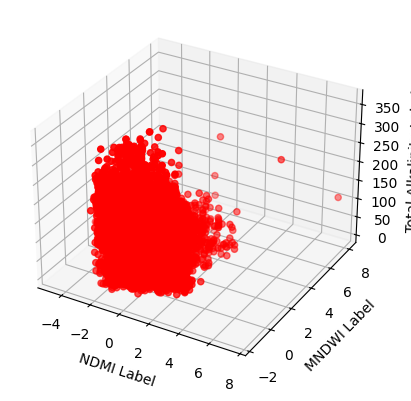

In [3]:
#making a 3d plot of NDMI and MNDWI (x, y) data in full_dataset against "Total Alkalinity" (z)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(full_dataset['NDMI'], full_dataset['MNDWI'], full_dataset['Total Alkalinity'], c='r', marker='o')
ax.set_xlabel('NDMI Label')
ax.set_ylabel('MNDWI Label')
ax.set_zlabel('Total Alkalinity Label')
plt.show()

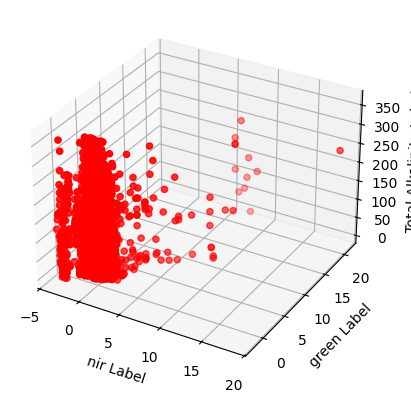

In [4]:
#making a 3d plot of nir and green (x, y) data in full_dataset against "Total Alkalinity" (z)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(full_dataset['nir'], full_dataset['green'], full_dataset['Total Alkalinity'], c='r', marker='o')
ax.set_xlabel('nir Label')
ax.set_ylabel('green Label')
ax.set_zlabel('Total Alkalinity Label')
plt.show()

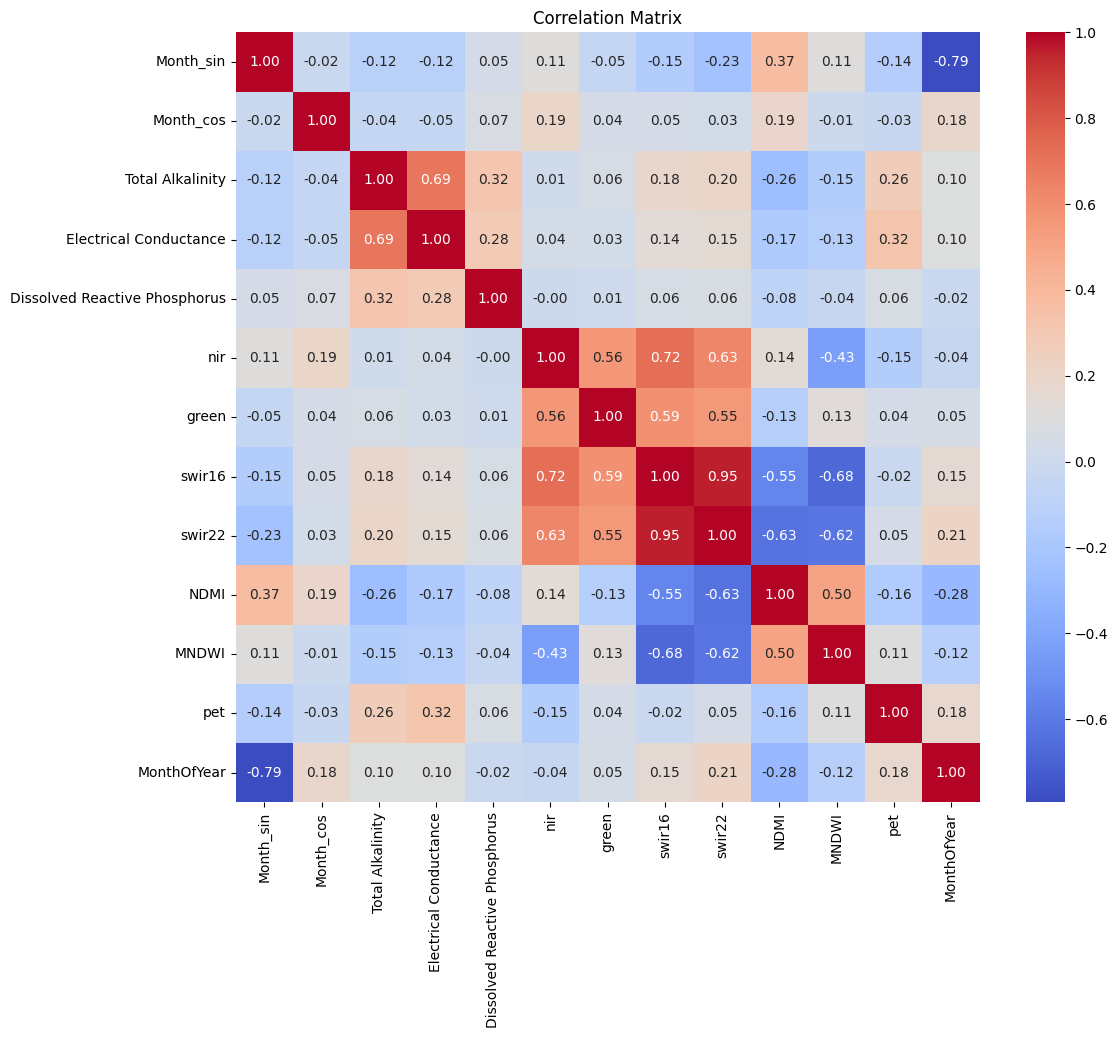

In [5]:
# plotting a correlation Matrix of all the data in full_dataset ( excluding "Latitude", "Longitude", "Sample Date")
correlation_matrix = full_dataset.drop(columns=['Latitude', 'Longitude', 'Sample Date']).corr()
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


### This Plot hihglights ONLY Linear Relationships, we'll plot those relationships and then we will see if there is any qadratic / cubic relationships between variables
### Ploting Strong Correlation variables, in linear analysis

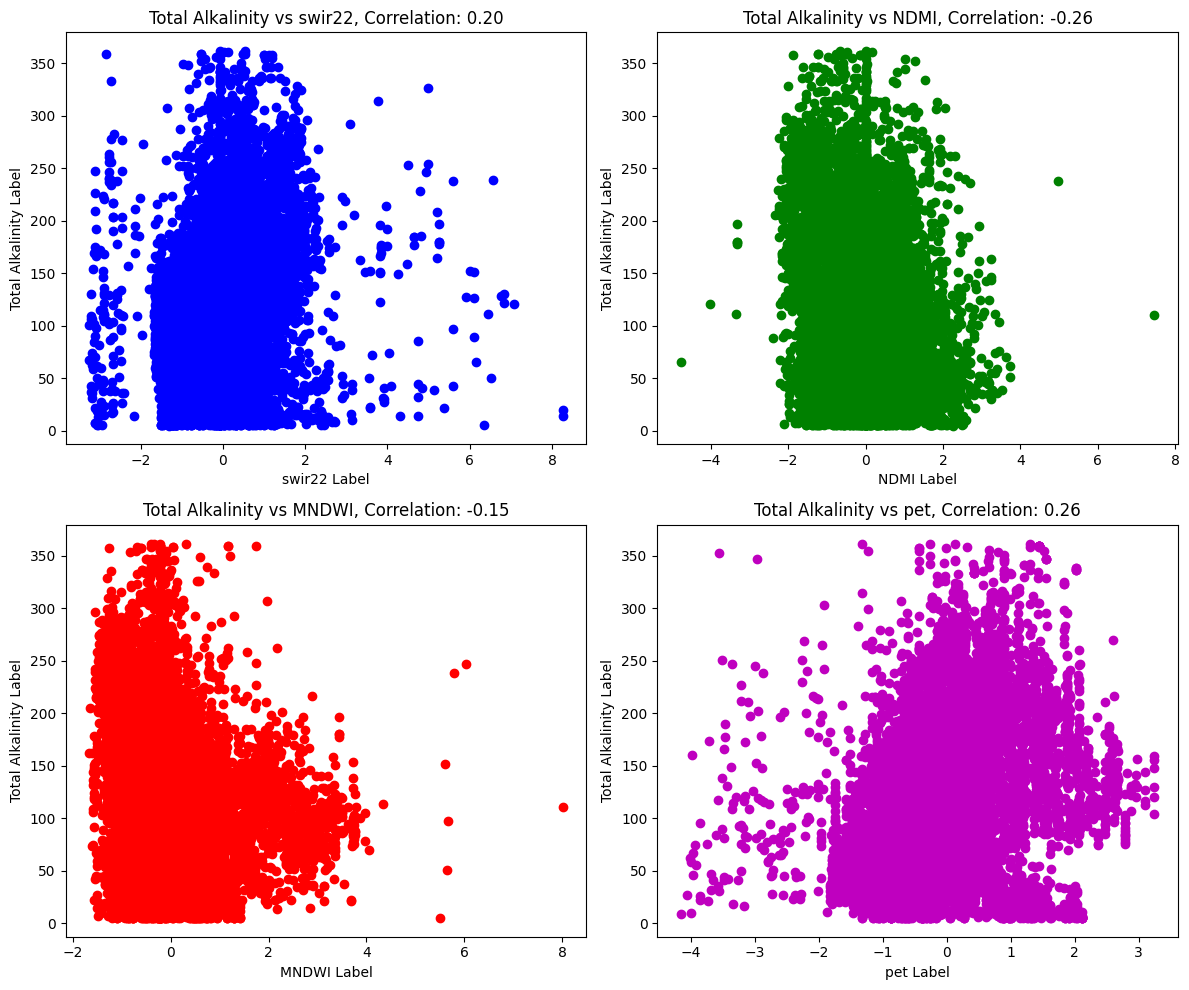

In [6]:
# making 4 plots: "Total Alkalinity" against "swir22", "NDMI", "MNDWI", "pet"
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs[0, 0].scatter(full_dataset['swir22'], full_dataset['Total Alkalinity'], c='b', marker='o')
axs[0, 0].set_xlabel('swir22 Label')
axs[0, 0].set_ylabel('Total Alkalinity Label')
axs[0, 0].set_title(f'Total Alkalinity vs swir22, Correlation: {correlation_matrix.loc["swir22", "Total Alkalinity"]:.2f}')
axs[0, 1].scatter(full_dataset['NDMI'], full_dataset['Total Alkalinity'], c='g', marker='o')
axs[0, 1].set_xlabel('NDMI Label')
axs[0, 1].set_ylabel('Total Alkalinity Label')
axs[0, 1].set_title(f'Total Alkalinity vs NDMI, Correlation: {correlation_matrix.loc["NDMI", "Total Alkalinity"]:.2f}')
axs[1, 0].scatter(full_dataset['MNDWI'], full_dataset['Total Alkalinity'], c='r', marker='o')
axs[1, 0].set_xlabel('MNDWI Label')
axs[1, 0].set_ylabel('Total Alkalinity Label')
axs[1, 0].set_title(f'Total Alkalinity vs MNDWI, Correlation: {correlation_matrix.loc["MNDWI", "Total Alkalinity"]:.2f}')
axs[1, 1].scatter(full_dataset['pet'], full_dataset['Total Alkalinity'], c='m', marker='o')
axs[1, 1].set_xlabel('pet Label')
axs[1, 1].set_ylabel('Total Alkalinity Label')
axs[1, 1].set_title(f'Total Alkalinity vs pet, Correlation: {correlation_matrix.loc["pet", "Total Alkalinity"]:.2f}')
plt.tight_layout()
plt.show()

### Adding quadratic data

In [7]:
quadradic_full_dataset = full_dataset.copy()
quadradic_full_dataset['swir22_squared'] = quadradic_full_dataset['swir22'] ** 2
quadradic_full_dataset['NDMI_squared'] = quadradic_full_dataset['NDMI'] ** 2
quadradic_full_dataset['MNDWI_squared'] = quadradic_full_dataset['MNDWI'] ** 2
quadradic_full_dataset['pet_squared'] = quadradic_full_dataset['pet'] ** 2
quadradic_full_dataset['nir_squared'] = quadradic_full_dataset['nir'] ** 2
quadradic_full_dataset['green_squared'] = quadradic_full_dataset['green'] ** 2
quadradic_full_dataset['swir16_squared'] = quadradic_full_dataset['swir16'] ** 2

quadradic_full_dataset.drop(columns=['MNDWI', 'NDMI', 'swir22', 'pet', 'nir', 'green', 'swir16'], inplace=True)
quadradic_full_dataset.head()

,Latitude,Longitude,Sample Date,Month_sin,Month_cos,Total Alkalinity,Electrical Conductance,Dissolved Reactive Phosphorus,MonthOfYear,swir22_squared,NDMI_squared,MNDWI_squared,pet_squared,nir_squared,green_squared,swir16_squared
0,-28.760833,17.730278,2011-01-02,0.5,0.866025,128.912,555.0,10.0,-1.633588,2.465786,5.025952,13.840926,0.001075,1.069856,0.314028,3.508486
1,-26.861111,28.884722,2011-01-03,0.5,0.866025,74.720,162.9,163.0,-1.633588,0.120867,1.985598,0.129299,3.003000,1.678768,0.024870,0.002685
2,-26.450000,28.085833,2011-01-03,0.5,0.866025,89.254,573.0,80.0,-1.633588,1.360309,2.044342,1.319499,2.616430,0.171149,0.084183,1.945684
3,-27.671111,27.236944,2011-01-03,0.5,0.866025,82.000,203.6,101.0,-1.633588,0.000003,0.132524,0.204089,2.380484,0.088419,0.141002,0.000380
4,-27.356667,27.286389,2011-01-03,0.5,0.866025,56.100,145.1,151.0,-1.633588,0.542104,2.675111,0.002217,2.433130,0.993410,0.030935,0.085035


### Checking for quadratic relationships

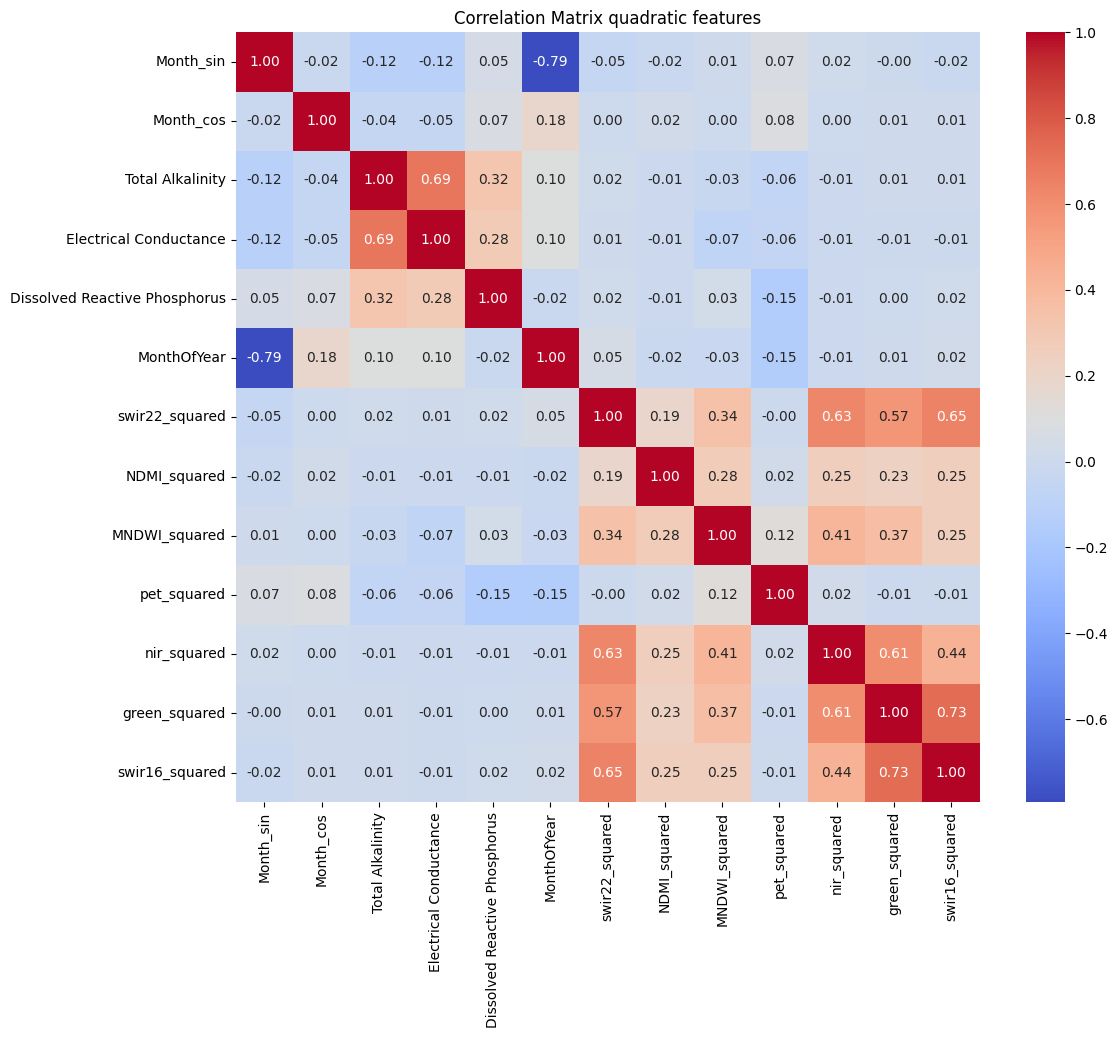

In [8]:
correlation_matrix = quadradic_full_dataset.drop(columns=['Latitude', 'Longitude', 'Sample Date']).corr()
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix quadratic features')
plt.show()

### Seing Cubic Relationship

In [9]:
cubic_full_dataset = full_dataset.copy()
cubic_full_dataset['swir22_cubed'] = cubic_full_dataset['swir22'] ** 3
cubic_full_dataset['NDMI_cubed'] = cubic_full_dataset['NDMI'] ** 3
cubic_full_dataset['MNDWI_cubed'] = cubic_full_dataset['MNDWI'] ** 3
cubic_full_dataset['pet_cubed'] = cubic_full_dataset['pet'] ** 3
cubic_full_dataset['nir_cubed'] = cubic_full_dataset['nir'] ** 3
cubic_full_dataset['green_cubed'] = cubic_full_dataset['green'] ** 3
cubic_full_dataset['swir16_cubed'] = cubic_full_dataset['swir16'] ** 3

cubic_full_dataset.drop(columns=['MNDWI', 'NDMI', 'swir22', 'pet', 'nir', 'green', 'swir16'], inplace=True)
cubic_full_dataset.head()

,Latitude,Longitude,Sample Date,Month_sin,Month_cos,Total Alkalinity,Electrical Conductance,Dissolved Reactive Phosphorus,MonthOfYear,swir22_cubed,NDMI_cubed,MNDWI_cubed,pet_cubed,nir_cubed,green_cubed,swir16_cubed
0,-28.760833,17.730278,2011-01-02,0.5,0.866025,128.912,555.0,10.0,-1.633588,-3.871979e+00,11.267497,51.492945,-0.000035,-1.106593,0.175976,-6.571728
1,-26.861111,28.884722,2011-01-03,0.5,0.866025,74.720,162.9,163.0,-1.633588,-4.202046e-02,2.797932,-0.046494,-5.203949,2.175134,-0.003922,0.000139
2,-26.450000,28.085833,2011-01-03,0.5,0.866025,89.254,573.0,80.0,-1.633588,1.586560e+00,-2.923009,-1.515701,-4.232176,0.070804,0.024425,2.713990
3,-27.671111,27.236944,2011-01-03,0.5,0.866025,82.000,203.6,101.0,-1.633588,-4.235805e-09,0.048244,0.092199,-3.672806,0.026292,0.052947,-0.000007
4,-27.356667,27.286389,2011-01-03,0.5,0.866025,56.100,145.1,151.0,-1.633588,-3.991387e-01,4.375349,0.000104,-3.795315,0.990131,-0.005441,-0.024797


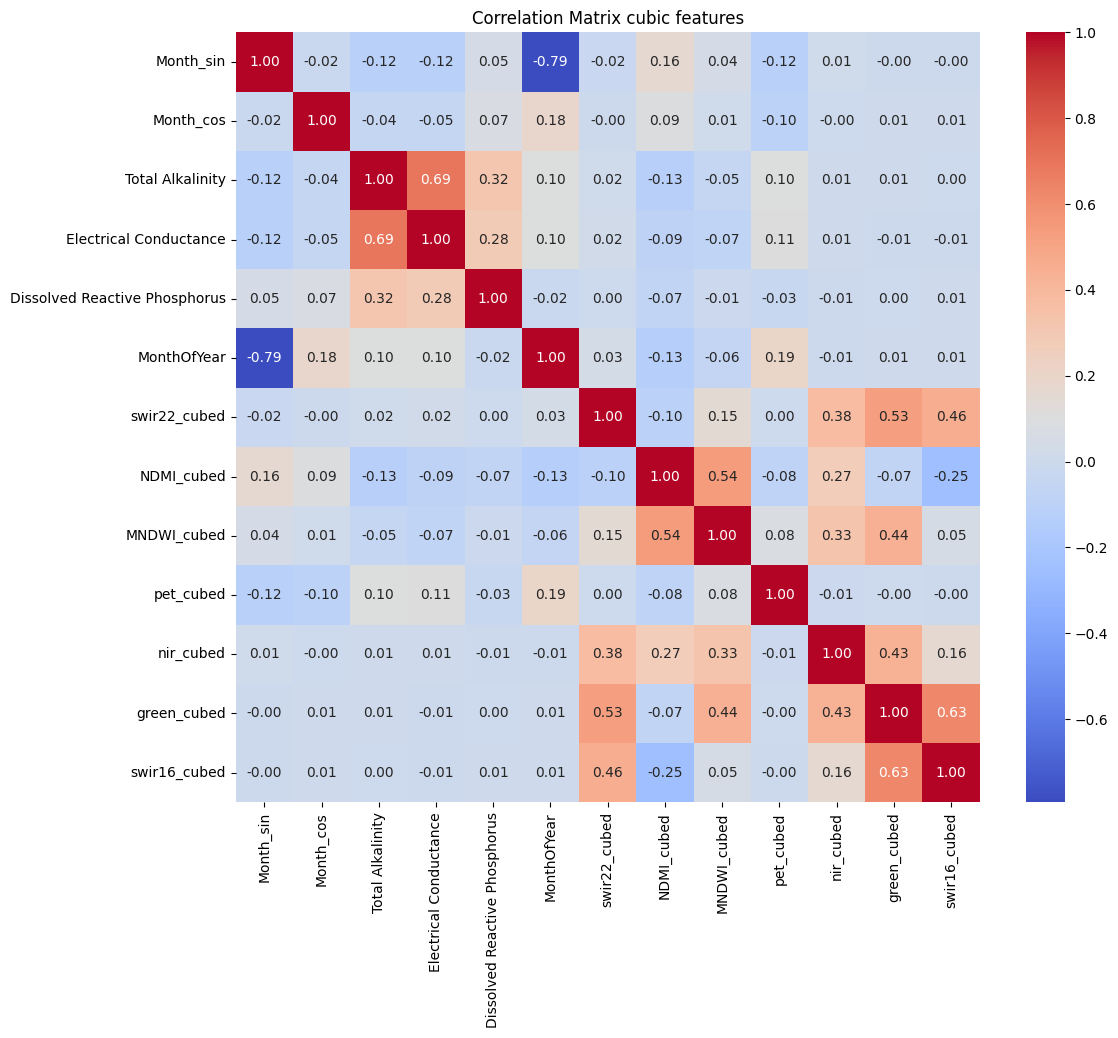

In [10]:
correlation_matrix = cubic_full_dataset.drop(columns=['Latitude', 'Longitude', 'Sample Date']).corr()
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix cubic features')
plt.show()

### Creating Simple Linear Model

In [24]:
all_data = combine_two_datasets(full_dataset, quadradic_full_dataset)
all_data = combine_two_datasets(all_data, cubic_full_dataset)
print(all_data.columns)
all_data.head()


Index(['Latitude', 'Longitude', 'Sample Date', 'Month_sin', 'Month_cos',
       'Total Alkalinity', 'Electrical Conductance',
       'Dissolved Reactive Phosphorus', 'nir', 'green', 'swir16', 'swir22',
       'NDMI', 'MNDWI', 'pet', 'MonthOfYear', 'swir22_squared', 'NDMI_squared',
       'MNDWI_squared', 'pet_squared', 'nir_squared', 'green_squared',
       'swir16_squared', 'swir22_cubed', 'NDMI_cubed', 'MNDWI_cubed',
       'pet_cubed', 'nir_cubed', 'green_cubed', 'swir16_cubed'],
      dtype='object')


,Latitude,Longitude,Sample Date,Month_sin,Month_cos,Total Alkalinity,Electrical Conductance,Dissolved Reactive Phosphorus,nir,green,...,nir_squared,green_squared,swir16_squared,swir22_cubed,NDMI_cubed,MNDWI_cubed,pet_cubed,nir_cubed,green_cubed,swir16_cubed
0,-28.760833,17.730278,2011-01-02,0.5,0.866025,128.912,555.0,10.0,-1.034338,0.560382,...,1.069856,0.314028,3.508486,-3.871979e+00,11.267497,51.492945,-0.000035,-1.106593,0.175976,-6.571728
1,-26.861111,28.884722,2011-01-03,0.5,0.866025,74.720,162.9,163.0,1.295673,-0.157702,...,1.678768,0.024870,0.002685,-4.202046e-02,2.797932,-0.046494,-5.203949,2.175134,-0.003922,0.000139
2,-26.450000,28.085833,2011-01-03,0.5,0.866025,89.254,573.0,80.0,0.413701,0.290144,...,0.171149,0.084183,1.945684,1.586560e+00,-2.923009,-1.515701,-4.232176,0.070804,0.024425,2.713990
3,-27.671111,27.236944,2011-01-03,0.5,0.866025,82.000,203.6,101.0,0.297354,0.375502,...,0.088419,0.141002,0.000380,-4.235805e-09,0.048244,0.092199,-3.672806,0.026292,0.052947,-0.000007
4,-27.356667,27.286389,2011-01-03,0.5,0.866025,56.100,145.1,151.0,0.996699,-0.175884,...,0.993410,0.030935,0.085035,-3.991387e-01,4.375349,0.000104,-3.795315,0.990131,-0.005441,-0.024797


In [25]:

feature_input_columns = all_data.columns.drop(['Latitude', 'Longitude', 'Sample Date', 'Total Alkalinity', 'Electrical Conductance', 'Dissolved Reactive Phosphorus'])
target_columns = ['Total Alkalinity', 'Electrical Conductance', 'Dissolved Reactive Phosphorus']



In [26]:
max_iterations = 4000

model_ridge = Ridge(alpha = 0.001, max_iter= max_iterations)
model_lasso = Lasso(alpha = 0.001, max_iter= max_iterations)
model_lasso



,"alpha alpha: float, default=1.0Constant that multiplies the L1 term, controlling regularizationstrength. `alpha` must be a non-negative float i.e. in `[0, inf)`.When `alpha = 0`, the objective is equivalent to ordinary leastsquares, solved by the :class:`LinearRegression` object. For numericalreasons, using `alpha = 0` with the `Lasso` object is not advised.Instead, you should use the :class:`LinearRegression` object.",0.001
,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"precompute precompute: bool or array-like of shape (n_features, n_features), default=FalseWhether to use a precomputed Gram matrix to speed upcalculations. The Gram matrix can also be passed as argument.For sparse input this option is always ``False`` to preserve sparsity.",False
,"copy_X copy_X: bool, default=TrueIf ``True``, X will be copied; else, it may be overwritten.",True
,"max_iter max_iter: int, default=1000The maximum number of iterations.",4000
,"tol tol: float, default=1e-4The tolerance for the optimization: if the updates are smaller or equal to``tol``, the optimization code checks the dual gap for optimality and continuesuntil it is smaller or equal to ``tol``, see Notes below.",0.0001
,"warm_start warm_start: bool, default=FalseWhen set to ``True``, reuse the solution of the previous call to fit asinitialization, otherwise, just erase the previous solution.See :term:`the Glossary `.",False
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive.",False
,"random_state random_state: int, RandomState instance, default=NoneThe seed of the pseudo random number generator that selects a randomfeature to update. Used when ``selection`` == 'random'.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",None
,"selection selection: {'cyclic', 'random'}, default='cyclic'If set to 'random', a random coefficient is updated every iterationrather than looping over features sequentially by default. This(setting to 'random') often leads to significantly faster convergenceespecially when tol is higher than 1e-4.",'cyclic'


In [27]:

train, test = train_test_split(all_data, test_size=0.25)

X_train = train[feature_input_columns]
y_train = train[target_columns]


X_test = test[feature_input_columns]
y_test = test[target_columns]

y_test.head()



,Total Alkalinity,Electrical Conductance,Dissolved Reactive Phosphorus
5944,123.846,614.0,20.0
6265,53.825,1173.0,20.0
3730,47.952,223.4,10.0
8484,31.047,1055.0,20.0
5866,229.566,547.0,36.0


In [28]:
model_ridge.fit(X_train, y_train)
model_lasso.fit(X_train, y_train)

#getting training error of each model
y_train_pred_ridge = model_ridge.predict(X_train)
y_train_pred_lasso = model_lasso.predict(X_train)

y_test_pred_ridge = model_ridge.predict(X_test)
y_test_pred_lasso = model_lasso.predict(X_test)



C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.605e+07, tolerance: 3.907e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.347e+08, tolerance: 8.362e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consi

In [29]:
evaluate_model(y_test_pred_ridge, y_test, dataset_name=' all data_test Ridge Regression')
evaluate_model(y_test_pred_lasso, y_test, dataset_name=' all data_test Lasso Regression')
print("\n \n")

evaluate_model(y_train_pred_ridge, y_train, dataset_name=' all data_train Ridge Regression')
evaluate_model(y_train_pred_lasso, y_train, dataset_name=' all data_train Lasso Regression')


 all data_test Ridge Regression Evaluation:
R²: 0.137
RMSE: 179.448

 all data_test Lasso Regression Evaluation:
R²: 0.137
RMSE: 179.450

 


 all data_train Ridge Regression Evaluation:
R²: 0.153
RMSE: 185.279

 all data_train Lasso Regression Evaluation:
R²: 0.153
RMSE: 185.282


(array([[118.13080861, 491.48779815,  57.96295464],
        [134.73274324, 626.59908622,  44.59734701],
        [150.81886674, 689.66651475,  63.34167074],
        ...,
        [ 99.46099699, 386.61235756,  33.96855469],
        [ 99.01626726, 381.59814874,  27.69235844],
        [143.5829057 , 629.50650343,  54.39168003]]),
 0.15308297558742623,
 np.float64(185.28173526747494))

In [30]:
#using neural net 

Model = Sequential([
    tf.keras.Input(shape=(X_train.shape[1],)),
    Dense(30, activation="relu"),
    Dense(40, activation="relu"),
    Dropout(0.05),
    Dense(50, activation="relu"),
    Dropout(0.05),
    Dense(30, activation="relu"),
    Dense(10, activation="relu"),
    Dense(3, activation="linear")
])

Model.compile(optimizer=Adam(learning_rate=0.0003), loss="MSE") # tentar variar esse loss aqui

Model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 30)             │           750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 40)             │         1,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 50)             │         2,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 30)             │         1,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,913 (23.10 KB)

 Trainable params: 5,913 (23.10 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 126350.5078 - val_loss: 112299.8516
Epoch 2/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 103220.1562 - val_loss: 75131.6797
Epoch 3/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 76689.5156 - val_loss: 62781.6914
Epoch 4/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 64875.6289 - val_loss: 56880.3398
Epoch 5/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 58792.2461 - val_loss: 51611.2227
Epoch 6/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 53248.3555 - val_loss: 46349.0000
Epoch 7/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 48232.6172 - val_loss: 41405.9062
Epoch 8/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 43292.0117 - val_loss: 37435.4258
Epoch 9/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 39613.0273 - val_loss: 34682.6523
Epoch 10/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 37334.9375 - val_loss: 33225.0781
Epoch 11/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - l

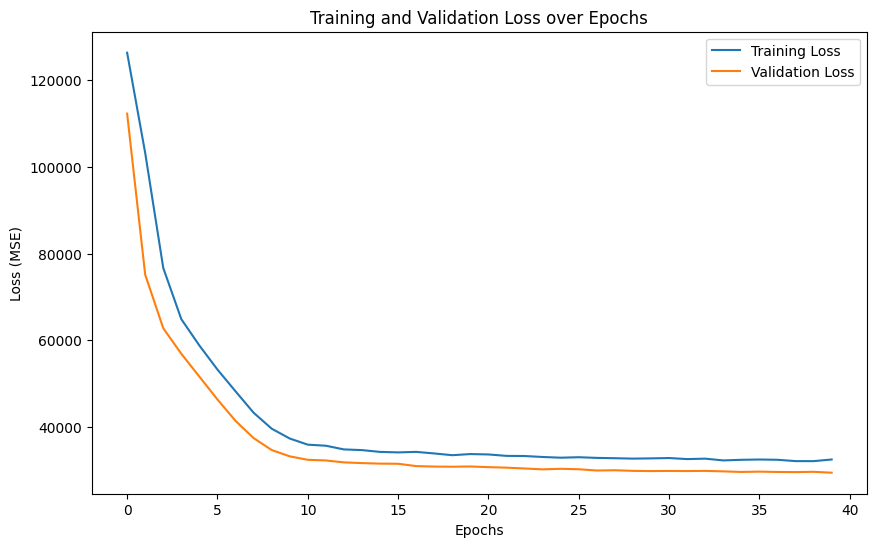

In [31]:
#training:

error_history = Model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=40, batch_size=32)

# plotting the error history:
plt.figure(figsize=(10, 6))
plt.plot(error_history.history['loss'], label='Training Loss')
plt.plot(error_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [32]:
y_train_neural_pred = Model.predict(X_train)
y_test_neural_pred = Model.predict(X_test)

y_train_neural_pred

evaluate_model(y_test_neural_pred, y_test, dataset_name=' all data_test Neural Network')
evaluate_model(y_train_neural_pred, y_train, dataset_name=' all data_train Neural Network')

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step

 all data_test Neural Network Evaluation:
R²: 0.151
RMSE: 171.591

 all data_train Neural Network Evaluation:
R²: 0.168
RMSE: 177.338


(array([[111.9944  , 477.47433 ,  41.710506],
        [153.78859 , 661.2992  ,  56.77245 ],
        [167.05878 , 716.33167 ,  61.060192],
        ...,
        [ 66.283615, 275.03775 ,  23.266565],
        [ 73.393036, 311.14212 ,  26.76315 ],
        [167.37592 , 717.83826 ,  61.103546]], dtype=float32),
 0.1678297072649002,
 np.float64(177.338135924355))

### Starting Submission Treatment

In [93]:
submission_landsat_data = pd.read_csv("../Datasets/landsat_features_validation.csv")
submission_terra_climate_data = pd.read_csv("../Datasets/terraclimate_features_validation.csv")

In [94]:
all_submission_data = combine_two_datasets(submission_landsat_data, submission_terra_climate_data)
all_submission_data

,Latitude,Longitude,Sample Date,nir,green,swir16,swir22,NDMI,MNDWI,pet
0,-32.043333,27.822778,01-09-2014,15229.0,12868.0,14797.0,12421.0,0.014388,-0.069727,161.900010
1,-33.329167,26.077500,16-09-2015,14525.5,9493.5,12425.5,9973.0,0.081427,-0.130571,177.600000
2,-32.991639,27.640028,07-05-2015,16221.0,9304.5,12536.5,9958.0,0.128123,-0.147979,158.400010
3,-34.096389,24.439167,07-02-2012,14525.5,9493.5,12425.5,9973.0,0.081427,-0.130571,130.000000
4,-32.000556,28.581667,01-10-2014,9125.0,11100.5,9455.0,8711.0,-0.017761,0.080052,152.500000
...,...,...,...,...,...,...,...,...,...,...
195,-33.771111,25.386667,06-12-2012,17562.0,9492.0,13559.5,10235.0,0.128609,-0.176453,171.400010
196,-33.185361,27.390750,04-09-2014,15883.0,9083.5,12135.5,9484.0,0.133751,-0.143833,159.400010
197,-32.043333,27.822778,28-09-2015,13619.5,10046.5,13105.0,10969.0,0.019252,-0.132108,168.600000
198,-33.001667,25.161389,08-01-2015,13955.5,10670.0,17303.5,14835.5,-0.107105,-0.237135,81.200005


In [95]:
#fabricando os dados a mais

all_submission_data['Sample Date'] = pd.to_datetime(all_submission_data['Sample Date'], dayfirst=True)
all_submission_data['MonthOfYear'] = all_submission_data['Sample Date'].dt.month
all_submission_data['Month_sin'] = np.sin(2 * np.pi * all_submission_data['MonthOfYear'] / MAX_CYCLE)
all_submission_data['Month_cos'] = np.cos(2 * np.pi * all_submission_data['MonthOfYear'] / MAX_CYCLE)

columns_to_remove = ['Latitude', 'Longitude', 'Sample Date', "Month_sin", "Month_cos" ]

#scaling splanatory variables

scaling_columns = all_submission_data.columns.drop(columns_to_remove)
scaled_array_features = scaler.transform(all_submission_data[scaling_columns].values)

df_scaled_submission_features = pd.DataFrame(
    scaled_array_features,
    columns=scaling_columns,
    index=all_submission_data.index # Manter o mesmo índice para fácil concatenação
    )

df_features_excluded_columns = all_submission_data[columns_to_remove]

full_dataset_features_scaled = pd.concat(
    [df_features_excluded_columns, df_scaled_submission_features], 
    axis=1
    )

quadradic_submission_full_dataset = full_dataset_features_scaled.copy()
quadradic_submission_full_dataset['swir22_squared'] = quadradic_submission_full_dataset['swir22'] ** 2
quadradic_submission_full_dataset['NDMI_squared'] = quadradic_submission_full_dataset['NDMI'] ** 2
quadradic_submission_full_dataset['MNDWI_squared'] = quadradic_submission_full_dataset['MNDWI'] ** 2
quadradic_submission_full_dataset['pet_squared'] = quadradic_submission_full_dataset['pet'] ** 2
quadradic_submission_full_dataset['nir_squared'] = quadradic_submission_full_dataset['nir'] ** 2
quadradic_submission_full_dataset['green_squared'] = quadradic_submission_full_dataset['green'] ** 2
quadradic_submission_full_dataset['swir16_squared'] = quadradic_submission_full_dataset['swir16'] ** 2
quadradic_submission_full_dataset.drop(columns=['MNDWI', 'NDMI', 'swir22', 'pet', 'nir', 'green', 'swir16'], inplace=True)


cubic_submission_full_dataset = full_dataset_features_scaled.copy()
cubic_submission_full_dataset['swir22_cubed'] = cubic_submission_full_dataset['swir22'] ** 3
cubic_submission_full_dataset['NDMI_cubed'] = cubic_submission_full_dataset['NDMI'] ** 3
cubic_submission_full_dataset['MNDWI_cubed'] = cubic_submission_full_dataset['MNDWI'] ** 3
cubic_submission_full_dataset['pet_cubed'] = cubic_submission_full_dataset['pet'] ** 3
cubic_submission_full_dataset['nir_cubed'] = cubic_submission_full_dataset['nir'] ** 3
cubic_submission_full_dataset['green_cubed'] = cubic_submission_full_dataset['green'] ** 3
cubic_submission_full_dataset['swir16_cubed'] = cubic_submission_full_dataset['swir16'] ** 3
cubic_submission_full_dataset.drop(columns=['MNDWI', 'NDMI', 'swir22', 'pet', 'nir', 'green', 'swir16'], inplace=True)
all_submission_data = combine_two_datasets(full_dataset_features_scaled, quadradic_submission_full_dataset)
all_submission_data = combine_two_datasets(all_submission_data, cubic_submission_full_dataset)

all_submission_data.head()

,Latitude,Longitude,Sample Date,Month_sin,Month_cos,nir,green,swir16,swir22,NDMI,...,nir_squared,green_squared,swir16_squared,swir22_cubed,NDMI_cubed,MNDWI_cubed,pet_cubed,nir_cubed,green_cubed,swir16_cubed
0,-32.043333,27.822778,2014-09-01,-1.000000,-1.836970e-16,0.420545,1.112343,0.385560,0.423315,-0.095694,...,0.176858,1.237306,0.148656,0.075856,-0.000876,0.591213,-0.091235,0.074377,1.376308,0.057316
1,-33.329167,26.077500,2015-09-16,-1.000000,-1.836970e-16,0.167138,-0.179329,-0.367855,-0.598528,0.819920,...,0.027935,0.032159,0.135317,-0.214415,0.551206,0.005698,0.000563,0.004669,-0.005767,-0.049777
2,-32.991639,27.640028,2015-05-07,0.500000,-8.660254e-01,0.777873,-0.251673,-0.332591,-0.604790,1.457693,...,0.605086,0.063340,0.110617,-0.221214,3.097406,-0.000001,-0.184174,0.470680,-0.015941,-0.036790
3,-34.096389,24.439167,2012-02-07,0.866025,5.000000e-01,0.167138,-0.179329,-0.367855,-0.598528,0.819920,...,0.027935,0.032159,0.135317,-0.214415,0.551206,0.005698,-3.600582,0.004669,-0.005767,-0.049777
4,-32.000556,28.581667,2014-10-01,-0.866025,5.000000e-01,-1.778170,0.435789,-1.311569,-1.125312,-0.534775,...,3.161888,0.189912,1.720213,-1.425015,-0.152937,14.990537,-0.455056,-5.622374,0.082762,-2.256177


In [99]:
X_pred_input_features_columns = all_submission_data.columns.drop(['Latitude', 'Longitude', 'Sample Date'])
X_pred_input_features = all_submission_data[X_pred_input_features_columns]
X_pred_input_features.columns

Index(['Month_sin', 'Month_cos', 'nir', 'green', 'swir16', 'swir22', 'NDMI',
       'MNDWI', 'pet', 'MonthOfYear', 'swir22_squared', 'NDMI_squared',
       'MNDWI_squared', 'pet_squared', 'nir_squared', 'green_squared',
       'swir16_squared', 'swir22_cubed', 'NDMI_cubed', 'MNDWI_cubed',
       'pet_cubed', 'nir_cubed', 'green_cubed', 'swir16_cubed'],
      dtype='object')

In [97]:
y_submission_pred = Model.predict(X_pred_input_features)
y_submission_pred

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


array([[103.12511 , 443.3066  ,  38.131966],
       [133.40201 , 572.94995 ,  49.235947],
       [111.46353 , 477.34277 ,  41.17323 ],
       [ 56.851784, 234.74254 ,  20.458817],
       [ 67.26904 , 263.42053 ,  22.56732 ],
       [148.74464 , 639.19    ,  54.66671 ],
       [ 60.563633, 234.0804  ,  20.215649],
       [ 82.55985 , 351.056   ,  30.229422],
       [112.08412 , 477.74777 ,  41.450264],
       [106.24303 , 455.31067 ,  39.243347],
       [ 98.15033 , 421.2084  ,  36.663628],
       [102.6227  , 439.90756 ,  38.16307 ],
       [ 48.635098, 157.08337 ,  13.214549],
       [ 96.378815, 409.54477 ,  35.828674],
       [ 62.51134 , 247.44055 ,  21.515179],
       [145.69733 , 625.76953 ,  53.457806],
       [ 89.12006 , 380.18088 ,  33.168015],
       [159.22127 , 684.37305 ,  58.33075 ],
       [ 98.15691 , 420.6708  ,  36.152584],
       [ 92.5677  , 396.09705 ,  34.06768 ],
       [102.07146 , 434.78018 ,  37.090603],
       [ 59.90124 , 246.72528 ,  21.304873],
       [12

In [104]:
predicted_values_pd = pd.DataFrame({
    'Total Alkalinity': y_submission_pred[:, 0], 
    'Electrical Conductance': y_submission_pred[:, 1], 
    'Dissolved Reactive Phosphorus': y_submission_pred[:, 2]
})

predicted_pd = pd.DataFrame({
    'Latitude': all_submission_data['Latitude'].values,
    'Longitude': all_submission_data['Longitude'].values,
    'Sample Date': all_submission_data['Sample Date'].values,
})
predicted_pd = pd.concat([predicted_pd, predicted_values_pd], axis=1)
predicted_pd.head()

,Latitude,Longitude,Sample Date,Total Alkalinity,Electrical Conductance,Dissolved Reactive Phosphorus
0,-32.043333,27.822778,2014-09-01,111.083160,293.600555,35.268333
1,-33.329167,26.077500,2015-09-16,182.778091,723.741455,40.623768
2,-32.991639,27.640028,2015-05-07,69.233467,946.355469,50.669815
3,-34.096389,24.439167,2012-02-07,60.576759,209.371429,26.621754
4,-32.000556,28.581667,2014-10-01,87.872330,413.778046,25.051701


In [55]:
predicted_pd.to_csv("../Results/submission_predictions.csv")

### Testing XGBoost


In [109]:
import xgboost as xgb 
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
# nao normalizar saída



In [110]:
X_train = train[feature_input_columns]
y_train = train[target_columns]


X_test = test[feature_input_columns]
y_test = test[target_columns]

y_test.head()

,Total Alkalinity,Electrical Conductance,Dissolved Reactive Phosphorus
5944,123.846,614.0,20.0
6265,53.825,1173.0,20.0
3730,47.952,223.4,10.0
8484,31.047,1055.0,20.0
5866,229.566,547.0,36.0


In [111]:
X_train.head()

,Month_sin,Month_cos,nir,green,swir16,swir22,NDMI,MNDWI,pet,MonthOfYear,...,nir_squared,green_squared,swir16_squared,swir22_cubed,NDMI_cubed,MNDWI_cubed,pet_cubed,nir_cubed,green_cubed,swir16_cubed
9175,-0.500000,8.660254e-01,-1.055771,0.066986,-1.122540,-0.766331,0.404545,1.643237,0.615371,1.366808,...,1.114652,0.004487,1.260096,-0.450038,0.066206,4.437112,0.233029,-1.176817,3.005765e-04,-1.414509
462,0.500000,-8.660254e-01,0.523745,0.109091,-0.241571,-0.418829,1.005467,0.383957,0.567862,-0.433430,...,0.274309,0.011901,0.058357,-0.073470,1.016490,0.056604,0.183117,0.143668,1.298287e-03,-0.014097
7491,0.866025,5.000000e-01,1.125654,0.259330,0.809842,0.774366,0.139851,-0.631513,1.107425,-1.333549,...,1.267097,0.067252,0.655844,0.464342,0.002735,-0.251852,1.358135,1.426314,1.744052e-02,0.531129
5452,1.000000,6.123234e-17,-0.266013,0.096077,-0.932558,-0.924116,1.231929,1.370011,0.092775,-1.033509,...,0.070763,0.009231,0.869665,-0.789186,1.869637,2.571412,0.000799,-0.018824,8.868664e-04,-0.811013
3951,0.500000,-8.660254e-01,0.356248,-0.003444,-0.753696,-0.900740,1.704621,0.950993,-0.083686,-0.433430,...,0.126913,0.000012,0.568057,-0.730801,4.953172,0.860067,-0.000586,0.045212,-4.086082e-08,-0.428142


In [123]:
boost_predicter = xgb.XGBRegressor(
    objective ='reg:squarederror',
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
)



In [124]:
history = boost_predicter.fit(
    X_train,
    y_train,
    verbose=True,
)

y_pred = boost_predicter.predict(X_test)

In [125]:
y_pred
evaluate_model(y_pred, y_test, dataset_name=' all data_test boosted tree')


 all data_test boosted tree Evaluation:
R²: 0.422
RMSE: 147.613


(array([[116.99225 , 576.97437 , 106.41394 ],
        [ 46.09812 , 577.8031  ,  31.450853],
        [ 28.878736, 265.47226 ,  10.175572],
        ...,
        [177.69511 , 627.95685 ,  70.401054],
        [104.42368 , 300.7329  ,  10.606036],
        [ 88.688835, 288.7235  ,   6.249778]], dtype=float32),
 0.42157450318336487,
 np.float64(147.6132179358441))

In [121]:
y_submission_pred = boost_predicter.predict(X_pred_input_features)
y_submission_pred

array([[105.42032  , 330.241    ,  19.840353 ],
       [144.18607  , 605.7084   ,  66.04812  ],
       [ 94.148705 , 613.92053  ,  41.200584 ],
       [ 77.40623  , 189.90182  ,  17.851048 ],
       [106.91365  , 334.01102  ,  22.027712 ],
       [112.655594 , 529.889    ,  27.218637 ],
       [101.649994 , 335.40826  ,   8.286258 ],
       [ 77.27388  , 275.10184  ,  37.710655 ],
       [107.52149  , 308.74768  ,  15.860447 ],
       [105.21772  , 399.73727  ,  33.1363   ],
       [ 46.366367 , 262.53473  ,  47.454147 ],
       [ 58.645603 , 386.56815  ,  42.303608 ],
       [ 53.092762 , 162.61116  ,  10.464639 ],
       [111.122734 , 395.44952  ,  15.825569 ],
       [ 75.49702  , 217.46611  ,   9.859383 ],
       [170.09549  , 649.4505   ,  48.447193 ],
       [ 53.893883 , 497.79736  ,  34.183598 ],
       [139.10208  , 579.3312   ,  41.463715 ],
       [105.15479  , 370.6158   ,  13.385875 ],
       [117.24121  , 311.62906  ,  18.087887 ],
       [107.60762  , 368.6498   ,  16.58

In [122]:
predicted_values_pd = pd.DataFrame({
    'Total Alkalinity': y_submission_pred[:, 0], 
    'Electrical Conductance': y_submission_pred[:, 1], 
    'Dissolved Reactive Phosphorus': y_submission_pred[:, 2]
})

predicted_pd = pd.DataFrame({
    'Latitude': all_submission_data['Latitude'].values,
    'Longitude': all_submission_data['Longitude'].values,
    'Sample Date': all_submission_data['Sample Date'].values,
})
predicted_pd = pd.concat([predicted_pd, predicted_values_pd], axis=1)
predicted_pd.head()

,Latitude,Longitude,Sample Date,Total Alkalinity,Electrical Conductance,Dissolved Reactive Phosphorus
0,-32.043333,27.822778,2014-09-01,105.420319,330.240997,19.840353
1,-33.329167,26.077500,2015-09-16,144.186066,605.708374,66.048119
2,-32.991639,27.640028,2015-05-07,94.148705,613.920532,41.200584
3,-34.096389,24.439167,2012-02-07,77.406227,189.901825,17.851048
4,-32.000556,28.581667,2014-10-01,106.913651,334.011017,22.027712


In [117]:
predicted_pd.to_csv("../Results/submission_predictions_boosted_tree.csv")